# Experiment 4: Adjacency Map as data structure for Graphs

[//]: # (------------------------------------------    DO NOT MODIFY THIS    ------------------------------------------)
<style type="text/css">
.tg  {border-collapse:collapse;
      border-spacing:0;
     }
.tg td{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg th{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       font-weight:normal;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg .tg-fymr{border-color:inherit;
             font-weight:bold;
             text-align:left;
             vertical-align:top
            }
.tg .tg-0pky{border-color:inherit;
             text-align:left;
             vertical-align:top
            }
[//]: # (--------------------------------------------------------------------------------------------------------------)

[//]: # (-------------------------------------    FILL THIS OUT WITH YOUR DATA    -------------------------------------)
</style>
<table class="tg">
    <tbody>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Title:</td>
        <td class="tg-0pky">Experiment 4: Adjacency Map as data structure for Graphs</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Authors:</td>
        <td class="tg-0pky">
            <a href="https://github.com/ecarrenolozano" target="_blank" rel="noopener noreferrer">Edwin Carreño</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Affiliations:</td>
        <td class="tg-0pky">
            <a href="https://www.ssc.uni-heidelberg.de/en" target="_blank" rel="noopener noreferrer">Scientific Software Center</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Date Created:</td>
        <td class="tg-0pky">30.10.2024</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Description:</td>
        <td class="tg-0pky">Creation of a graph using adjacency maps and data from CSV files. Conversion to NetworkX is tested too.</td>
      </tr>
    </tbody>
</table>

[//]: # (--------------------------------------------------------------------------------------------------------------)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  
</table>

## Overview

In this notebook we are going to:

1. Import CSV (comma-separated values) data from nodes and edges.
2. Describe the data from CSVs.
3. Create a data pipeline that:
   - load csv data.
   - transform the format of tuples that represents edges (from 5 to 3 elements).
   - transform the format of tuples that represents nodes (from 3 to 2 elements).
   - create a dictionary for nodes and an adjacency map for the graph.
4. Create a NetworkX graph from dictionary and adjancency map.

## Setup (if required)

The following function checks if a library of interest is installed. Depending on the parameter `install`, you can install it automatically.

In [1]:
import subprocess
from importlib.metadata import version
from importlib.util import find_spec

def check_package_install(package, install=False):
    if find_spec(package) is None:
        print(package,"is NOT installed in Python environment")
        if install:
            try:
                subprocess.check_call(["python", "-m", "pip", "install", package])
            except subprocess.CalledProcessError as e:
                print(f"\tError occurred: {e}")
                print(f"\tCheck the name of your package!")
            print(package, "has been installed with version: ", version(package))
    else:
        print(package,"is installed with version: ", version(package))

### NetworkX installation

In [2]:
check_package_install("networkx", install=False)

networkx is installed with version:  3.4.2


## Importing Libraries

In [3]:
"""
Recommendations:
    - Respect the order of the imports, they are indicated by the numbers 1, 2, 3.
    - One import per line is recommended, with this we can track easily any modified line when we use git.
    - Absolute imports are recommended (see 3. Local application/library specific imports below), they improve readability and give better error messages.
    - You should put a blank line between each group of imports.
"""

# future-imports (for instance: from __future__ import barry_as_FLUFL)
# from __future__ import barry_as_FLUFL  

# 1. Standard library imports
import ast
import csv
import os
from collections import defaultdict
from itertools import islice

# 2. Related third party imports
import networkx as nx
from IPython.display import Image

# 3. Local application/library specific imports
# import <mypackage>.<MyClass>         # this is an example
# from <mypackage> import <MyClass>    # this is another example 

## Helper Functions

In [4]:
def load_csv_generator(file_path, header=True):
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        if header:
            next(reader)
        for row in reader:
            yield tuple(row)

def to_networkx_nodes_format(nodes_iterable, mapping_properties=True):
    for (node_id, node_label, properties) in nodes_iterable:
        # Original format
        #  (node id, node label, properties)

        # Desired format
        #  (node id, properties as dict)

        properties = ast.literal_eval(properties)

        if mapping_properties:
            properties["node_label"] = node_label

        yield(
            node_id,
            properties
        )

def to_networkx_edges_format(edges_iterable, mapping_properties=True):
    for (edge_id, source_id, target_id, edge_label, properties) in edges_iterable:
        # Original format
        #  (edge id, source (edge id), target (edge id), label, properties)

        # Desired format
        #  (source (edge id), target (edge id), properties as dict)

        properties = ast.literal_eval(properties)

        if mapping_properties:
            properties["edge_id"] = edge_id
            properties["edge_label"] = edge_label

        yield (
            source_id,
            target_id,
            properties,
        )

def generate_nodes_dict(generator_nodes):
    return {node:properties for (node, properties) in generator_nodes}

def create_adjacency_map(generator_edges):
    
    adjacency_map = defaultdict(dict)   

    for (source_id, target_id, properties) in generator_edges:
            adjacency_map[source_id][target_id] = properties
    
    return adjacency_map

def create_dictionaries():
    nodes_ds = load_csv_generator(file_path_nodes, header=True)
    nodes_ds = to_networkx_nodes_format(nodes_ds)
    nodes_ds = generate_nodes_dict(nodes_ds)

    edges_ds = load_csv_generator(file_path_edges, header=True)
    edges_ds = to_networkx_edges_format(edges_ds)
    edges_ds = create_adjacency_map(edges_ds)

    return nodes_ds, edges_ds

def networkx_graph_from_dicts(nodes_dict, adjacency_map, graph_type=nx.DiGraph()):
    # Create and populate graph using an adjacency map
    networkx_graph = nx.from_dict_of_dicts(adjacency_map, create_using=graph_type)

    # Populate nodes with properties
    networkx_graph.add_nodes_from(nodes_dict.items())

    return networkx_graph

## Introduction

A graph is collection of nodes and edges that expresses the relationship between nodes. A minimal node contain their `node label`. Similarly, a minimal edge contain the `source id`, `target id` and `label`.

The data for nodes and edges can be stored in form of tuples. Figure 1 shows the graph that can be constructed with the information from the dataset `dataset_dummy2_edges.csv` and `dataset_dummy2_nodes.csv` 

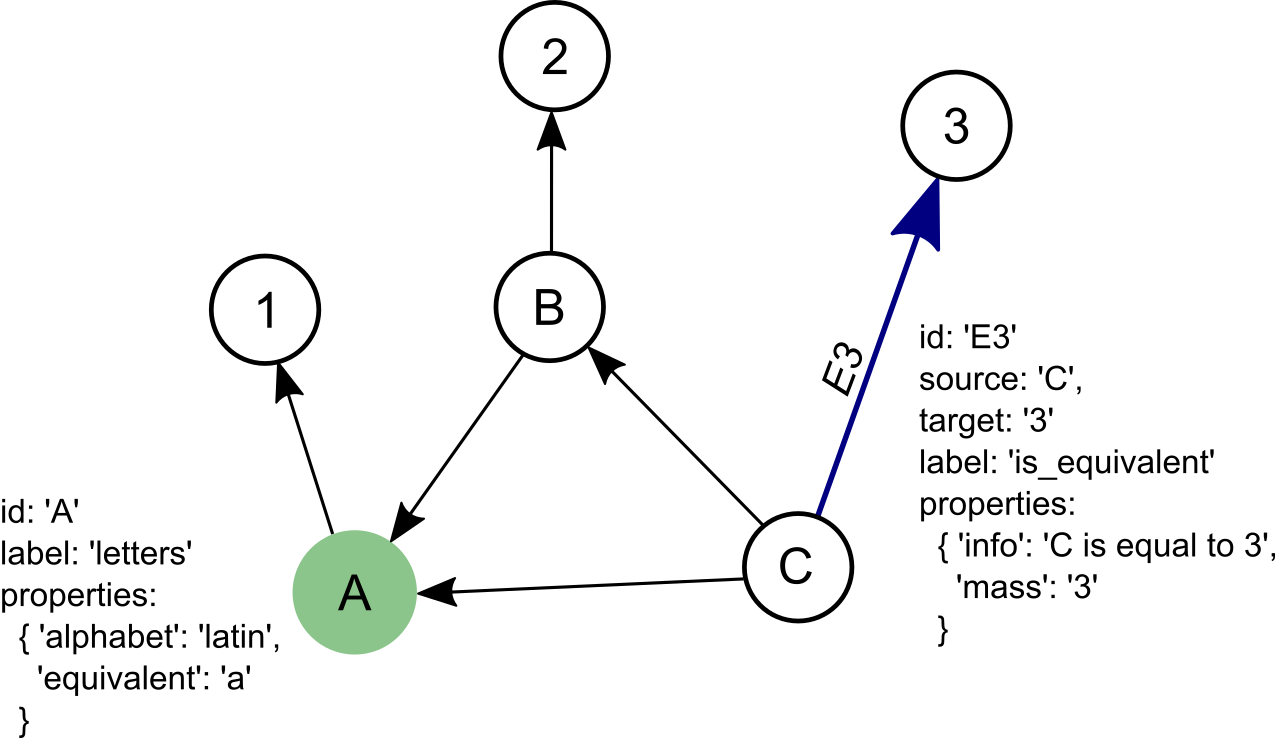

In [5]:
Image(filename="./images/graph_dataset_dummy2.png", width=600, height=600) 

In this notebook we are going to work with a little bit complex graphs (more nodes, and more edges). Additionally, each node and edge contain properties that are from our interest to keep in order to use for subsequent frameworks, i.e. machine learning and optimization frameworks.

## Section 1: Load the CSV data that contains nodes and edges

For this exercise, each graph is represented by two CSV files. One containing information about the **nodes** and the other about the **edges**. To indicate that both files correspond to the same graph, their names include the same number of nodes. For example:

- `dataset_30_nodes_proteins.csv`: contains 30 rows (nodes).
- `dataset_30_edges_interactions.csv`: contains 47 rows (edges).

We reference each CSV file or dataset as follows:

In [6]:
#filename_nodes = "dataset_dummy2_nodes.csv"
#filename_edges = "dataset_dummy2_edges.csv"

filename_nodes = "dataset_30_nodes_proteins.csv"
filename_edges = "dataset_30_edges_interactions.csv"

#-----------  Change the path we you have the datasets
# FILE_PATH_DATASETS = "../../../DATASETS"
FILE_PATH_DATASETS = "../data_examples"

### 1.1: Load Nodes

The CSV file for nodes contains three columns:
- `UniProt ID`
- `label`
- `properties`

We are going to load the information of nodes as a **list of tuples**. Each tuple represents a node with the structure:
- `(id, label, properties)`
- Each field in the tuple is a `string`
- The `properties` field is a string containing a dictionary of properties.

In [7]:
file_path_nodes = os.path.join(FILE_PATH_DATASETS, filename_nodes)

list_nodes_example = list(islice(load_csv_generator(file_path_nodes, header=True), 3))

In [8]:
print("The list of NODES contains: {} nodes".format(len(list_nodes_example)))
print("Examples:")
for node in list_nodes_example:
    print("{}".format(node))

The list of NODES contains: 3 nodes
Examples:
('G0P1I0', 'uniprot_protein', "{'sequence': 'QKRTLFKVEFGSMSWFYKHRTNMHLRTMMYD', 'description': 'Lorem ipsum ilymp', 'taxon': '7813'}")
('B6V6V7', 'uniprot_isoform', "{'sequence': 'CGLGLSMRFLMVGVQNWFWYGTRVPDVAYIDWHEYQHQPRVLMQNGN', 'description': 'Lorem ipsum kxujk', 'taxon': '4800'}")
('385603', 'entrez_protein', "{'sequence': 'EHYTERRSMRSTGQDKTSNPYLFFHITRFKRCPANQVKPWFMVLHKYEW', 'description': 'Lorem ipsum ufuuy', 'taxon': '9606'}")


### 1.2: Load Edges

The CSV file for edges contains five columns:
- `Relationship ID`
- `Source ID`
- `Target ID`
- `label`
- `properties`

We are going to load the information of edges as a list of tuples. Each tuple represents a node with thethe structure:
- `(id, source, target, label, properties)`
- Each field in the tuple is a `string`
- The `properties` field is string containing a dictionary of properties.

In [9]:
file_path_edges = os.path.join(FILE_PATH_DATASETS, filename_edges)

list_edges_example = list(islice(load_csv_generator(file_path_edges, header=True), 3))

In [10]:
print("The list of EDGES contains: {} edges".format(len(list_edges_example)))
print("Examples:")
for edge in list_edges_example:
    print("{}".format(edge))

The list of EDGES contains: 3 edges
Examples:
('', 'B6V6V7', 'H9R6K5', 'interacts_with', "{'source': 'signor'}")
('', 'B6V6V7', 'I5X3I2', 'interacts_with', "{'method': 'Lorem ipsum pblfc'}")
('', '385603', 'H9R6K5', 'interacts_with', "{'source': 'intact', 'method': 'Lorem ipsum nbqvj'}")


## Section 2: Create Data Pipeline

- **input:** CSV data of edges
- **output:** Dictionaries (nodes and adjacency map)

The pipeline consist of two consecutive stages:

| Stage | Function                      | Description |
|-------|-----------------------------| ----------- |
| 1     | `create_dictionaries()`     | function returning a dictionary for nodes and an adjacency map (dictionary) for edges     |
|       | `load_csv_generator()`      | read the csv and load the information as generator                                        |
|       | `to_networkx_nodes_format()`| generator that converts node tuples compatible with networkx (node, properties)           |
|       | `generate_nodes_dict()`     | dictionary comprenhension                                                                 |
|       | `load_csv_generator()`      | read the csv and load the information as generator                                        |
|       | `to_networkx_edges_format()`| generator that converts edge tuples compatible with networkx (source, target, properties) |
|       | `create_adjacency_map()`    | create an adjacency map with the information of edges                                     |

### 2.1 Create Adjacency Map (data structure)

In [11]:
nodes_dict, edges_adjacency_map = create_dictionaries()

## Section 3: Creating NetworkX
### Create Data Pipeline
- **input:** nodes dictionary and adjacency map
- **output:** A NetworkX graph

The pipeline consist of two consecutive stages:

| Stage | Function                 | Description |
|-------|--------------------------|--------------------------------------------------------------|
| 1     | `nx.from_dict_of_dicts()`| create a graph from a dictionary in form of an adjacency map |
|       | `graph.add_nodes_from()` | populate a graph with nodes including their properties       |

In [12]:
try:
    G.clear()
    print("Graph has been cleared!")
except:
    print("Graph G doesn't exist")

Graph G doesn't exist


### 3.1 Create a Directed Graph

In [13]:
G = networkx_graph_from_dicts(nodes_dict=nodes_dict,
                              adjacency_map=edges_adjacency_map,
                              graph_type=nx.DiGraph())

### 3.2 Draw Graph

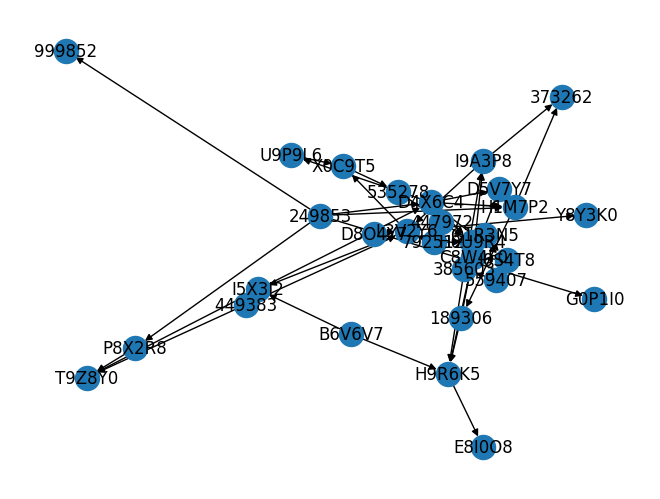

In [14]:
nx.draw(G, with_labels=True)

### 3.3 Some statistics

In [15]:
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

Number of nodes: 30
Number of edges: 47


In [16]:
limit = 5
for index, edge in enumerate(G.edges(data=True)):
    if index == limit:
        break
    print(edge)

('B6V6V7', 'H9R6K5', {'source': 'signor', 'edge_id': '', 'edge_label': 'interacts_with'})
('B6V6V7', 'I5X3I2', {'method': 'Lorem ipsum pblfc', 'edge_id': '', 'edge_label': 'interacts_with'})
('385603', 'H9R6K5', {'source': 'intact', 'method': 'Lorem ipsum nbqvj', 'edge_id': '', 'edge_label': 'interacts_with'})
('385603', 'I9A3P8', {'edge_id': '', 'edge_label': 'interacts_with'})
('L3V2Y6', 'X0C9T5', {'source': 'intact', 'method': 'Lorem ipsum zwhrq', 'edge_id': '', 'edge_label': 'interacts_with'})


In [17]:
limit = 5
for index, node in enumerate(G.nodes(data=True)):
    if index == limit:
        break
    print(node)

('B6V6V7', {'sequence': 'CGLGLSMRFLMVGVQNWFWYGTRVPDVAYIDWHEYQHQPRVLMQNGN', 'description': 'Lorem ipsum kxujk', 'taxon': '4800', 'node_label': 'uniprot_isoform'})
('385603', {'sequence': 'EHYTERRSMRSTGQDKTSNPYLFFHITRFKRCPANQVKPWFMVLHKYEW', 'description': 'Lorem ipsum ufuuy', 'taxon': '9606', 'node_label': 'entrez_protein'})
('L3V2Y6', {'sequence': 'EGYPSHLLDVESFMSHNWTPWIFKCDARLC', 'description': 'Lorem ipsum yueos', 'taxon': '3342', 'mass': 73, 'node_label': 'uniprot_protein'})
('Q1R3N5', {'sequence': 'IVHIKHTTQLGAIIQRNFQVGWCHVG', 'description': 'Lorem ipsum xyked', 'taxon': '5672', 'mass': 7347, 'node_label': 'uniprot_isoform'})
('249853', {'sequence': 'RYWCKKEDCLAIKLEWVNHTHCLVQKDGMCMNKKSHNCWAHDR', 'description': 'Lorem ipsum lskfp', 'taxon': '9606', 'node_label': 'entrez_protein'})
